# chewiness

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Chewiness
0  38.049816
1  31.294988
2  39.494747
3  26.862429
4  38.977081
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 4 candidates, totalling 44 fits
Mean_val_score   [ -8.17562526 -11.29862068 -12.87251546 -13.78981582]
Mean_train_score   [ -4.10603162  -5.60710812  -7.57185861 -10.09082981]
Ratio test/train   [1.99112575 2.01505312 1.70004699 1.36656906]
Best parameters   {'n_neighbors': 3}
Best parameters test score  8.17

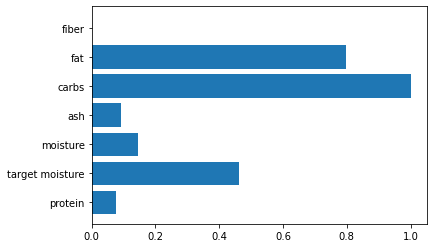

[0, 1, 2, 3, 4, 5, 6]
Number of features: 7
Features: Index(['protein', 'target moisture', 'moisture', 'ash', 'carbs', 'fat',
       'fiber'],
      dtype='object')
Root Mean Squared Error (RMSE): 11.122
Root Mean Squared Train Error (RMSE): 3.678
Adjusted r2_score: 0.501
r2_score: 0.567
Mean Absolute Percentage Error (MAPE): 23.9%
Mean Absolute Percentage Train Error (MAPE): 0.1%


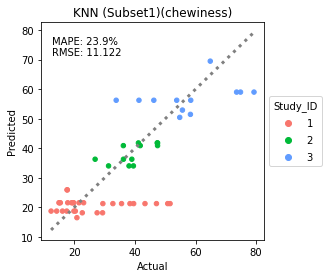

....................................................................................................
Feature: protein, Score: 0.07705
Feature: target moisture, Score: 0.46248
Feature: moisture, Score: 0.14446
Feature: ash, Score: 0.09193
Feature: carbs, Score: 1.00000
Feature: fat, Score: 0.79605
Feature: fiber, Score: 0.00000


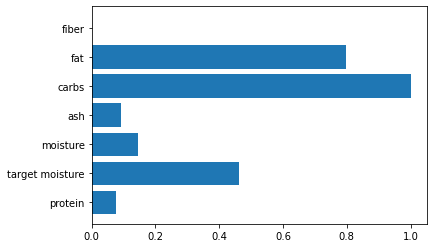

In [61]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut, GroupKFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[columns]

for sub_i in range(len(Subsets_Chew)):

    response = 'chewiness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

        #estimator: 100,300,500, ..1000 (did not matter)  lambda: 1.0  max_depth: 4

    param_grid = {
        'n_neighbors': [3,5,7,9]
    }
    ks =[3,5,7,9] # 5
    final_importance, final_importance_noabs=list(), list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = KNeighborsRegressor()#


    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_,predictions_train, y_trues_train = list(), list(), list(), list()
    labels, best_params= list(), list()
    importances, no_abs_importance=[],[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])


       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        #1 (return), 2 (root), 3 train predict, 4 eval
        reg = GridSearchCV(estimator=est,return_train_score=True, param_grid=param_grid, scoring='neg_root_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train)
        reg.cv_results_['mean_test_score']
        # 
        print("Mean_val_score  ", reg.cv_results_['mean_test_score'])
        print("Mean_train_score  ", reg.cv_results_['mean_train_score'])
        print("Ratio test/train  ", reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])
        best_params.append(reg.best_params_)
        print("Best parameters  ", reg.best_params_)
        print("Best parameters test score ",np.abs(reg.cv_results_['mean_test_score'][reg.best_index_]))
        print("Best parameters train score ",np.abs(reg.cv_results_['mean_train_score'][reg.best_index_]))
        print("Best parameters ratio test/train ",(reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])[reg.best_index_])

      #  print(reg)
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())
        prediction_tr = reg.predict(X_train)

        predictions_train.extend(prediction_tr)
        y_trues_train.extend(y_train.ravel())

        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          

        results =  permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
        print(results['importances_mean'])
        importances.append(np.abs(results['importances_mean']))
        no_abs_importance.append(results['importances_mean'])
        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    #x=np.abs(importance)
    print('before ',importance)

    no_abs_importance = np.array(no_abs_importance).mean(0)

    importance = (importance-min(importance))/(max(importance)-min(importance))
    print('after ',importance)

    if not np.isnan(importance[0]):
        final_importance.append(importance)
        
    if not np.isnan(no_abs_importance[0]):
        final_importance_noabs.append(no_abs_importance)

    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Root Mean Squared Train Error (RMSE): %.3f' % mean_squared_error(y_trues_train, predictions_train, squared=False)) 

    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean Absolute Percentage Error (MAPE): {error4:.1f}%')
    print(f'Mean Absolute Percentage Train Error (MAPE): {mean_absolute_percentage_error(y_trues_train, predictions_train):.1f}%')


    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('KNN (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)

    fs_scores=[]
    for i,v in enumerate(final_importance):
        print('Feature: %0s, Score: %.5f' % (features_all.iloc[:,feat].columns[i],v))
        fs_scores.append('%0s %.5f' % (features_all.iloc[:,feat].columns[i],v))
    pyplot.barh(features_all.iloc[:,feat].columns, final_importance)
    pyplot.show()
        

In [62]:
np.savetxt(fname='fs_best_params_'+response+'.txt' , X=best_params, fmt='%s')


In [63]:
np.savetxt(fname='./fs_scores_knn_'+response+'.txt',X=fs_scores,fmt='%s')

In [28]:
import os
os.getcwd()

'C:\\Users\\Sezin\\Documents\\FoodAI\\feature_selection\\30_12_12_leave_group_o\\Figures\\KNN'

In [32]:
best_params.split(' ')[1]

AttributeError: 'list' object has no attribute 'split'

In [7]:
reg.best_index_

0

In [8]:

reg.cv_results_['mean_test_score'][reg.best_index_]

-6.4975658713781685

In [8]:
loo.split(X,groups=groups)

<generator object BaseCrossValidator.split at 0x0000027F30417E40>

In [13]:
groups = list(data.Group_ID.unique())
m_groups = len(groups)
m_groups

12

In [14]:
k_fold

12

# On selected features

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Chewiness
0  38.049816
1  31.294988
2  39.494747
3  26.862429
4  38.977081
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 4 candidates, totalling 44 fits
Mean_val_score   [ -88.07770075  -99.75428769  -97.54413695 -120.05877628]
Mean_train_score   [-16.08793173 -29.78070095 -44.88878815 -60.1209802 ]
Ratio test/train   [5.47476843 3.3496286  2.17301783 1.99695307]
Best parameters   {'n_neighbors': 3}
Best parameters test score  

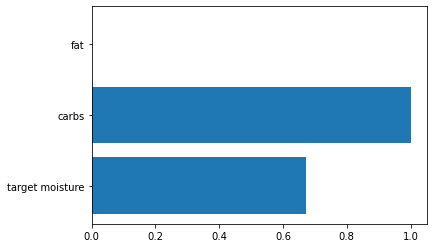

[1, 4, 5]
Number of features: 3
Features: Index(['target moisture', 'carbs', 'fat'], dtype='object')
Root Mean Squared Error (RMSE): 7.902
Root Mean Squared Train Error (RMSE): 4.592
Adjusted r2_score: 0.768
r2_score: 0.781
Mean Absolute Percentage Error (MAPE): 16.1%
Mean Absolute Percentage Train Error (MAPE): 0.1%


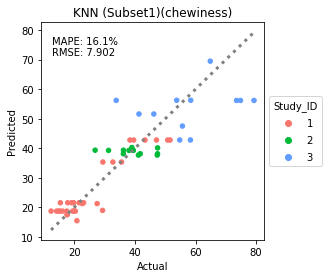

....................................................................................................
Feature: 0, Score: 0.67135
Feature: 1, Score: 1.00000
Feature: 2, Score: 0.00000


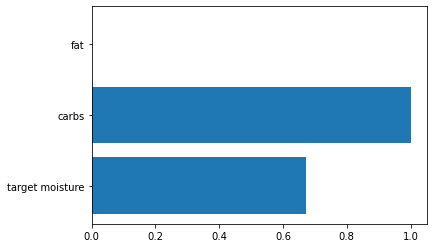

In [38]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut, GroupKFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[['target moisture','carbs','fat']]

for sub_i in range(len(Subsets_Chew)):

    response = 'chewiness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

        #estimator: 100,300,500, ..1000 (did not matter)  lambda: 1.0  max_depth: 4

    param_grid = {
        'n_neighbors': [3,5,7,9]
    }
    ks =[3,5,7,9] # 5
    final_importance=list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = KNeighborsRegressor()#


    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_,predictions_train, y_trues_train = list(), list(), list(), list()
    labels, best_params= list(), list()
    importances=[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])


       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        #1 (return), 2 (root), 3 train predict, 4 eval
        reg = GridSearchCV(estimator=est,return_train_score=True, param_grid=param_grid, scoring='neg_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train)
        # 
        print("Mean_val_score  ", reg.cv_results_['mean_test_score'])
        print("Mean_train_score  ", reg.cv_results_['mean_train_score'])
        print("Ratio test/train  ", reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])

        print("Best parameters  ", reg.best_params_)
        best_params.append(reg.best_params_)

        print("Best parameters test score ",np.sqrt(np.abs(reg.cv_results_['mean_test_score'][reg.best_index_])))
        print("Best parameters train score ",np.sqrt(np.abs(reg.cv_results_['mean_train_score'][reg.best_index_])))
        print("Best parameters ratio test/train ",(reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])[reg.best_index_])

      #  print(reg)
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())
        
        prediction_tr = reg.predict(X_train)
        predictions_train.extend(prediction_tr)
        y_trues_train.extend(y_train.ravel())

        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          

        results =  permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
       # print(results)
        importance = results.importances_mean
        x=np.abs(importance)

        importance = (x-min(x))/(max(x)-min(x))
        # summarize feature importance
        importances.append(importance)


        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    x=np.abs(importance)

    importance = (x-min(x))/(max(x)-min(x))
    if not np.isnan(importance[0]):
        final_importance.append(importance)
  #  for i,v in enumerate(importance):
  #      print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Root Mean Squared Train Error (RMSE): %.3f' % mean_squared_error(y_trues_train, predictions_train, squared=False)) 

    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean Absolute Percentage Error (MAPE): {error4:.1f}%')
    print(f'Mean Absolute Percentage Train Error (MAPE): {mean_absolute_percentage_error(y_trues_train, predictions_train):.1f}%')


    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('KNN (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)
    x=np.abs(final_importance)

    importance = (x-min(x))/(max(x)-min(x))
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()

In [39]:
np.savetxt(fname='best_params_'+response+'.txt' , X=best_params, fmt='%s')


# hardness

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Hardness
0   46.7090
1   40.4365
2   49.0595
3   38.6525
4   50.8115
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 4 candidates, totalling 44 fits
Mean_val_score   [-11.13828688 -15.05467851 -17.76164156 -18.97978366]
Mean_train_score   [ -4.65399174  -7.20045584  -9.82268553 -13.23290313]
Ratio test/train   [2.39327603 2.0907952  1.80822663 1.43428721]
Best parameters   {'n_neighbors': 3}
Best parameters test score  11.1382868

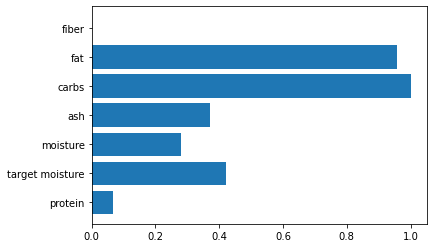

[0, 1, 2, 3, 4, 5, 6]
Number of features: 7
Features: Index(['protein', 'target moisture', 'moisture', 'ash', 'carbs', 'fat',
       'fiber'],
      dtype='object')
Root Mean Squared Error (RMSE): 14.298
Root Mean Squared Train Error (RMSE): 4.413
Adjusted r2_score: 0.528
r2_score: 0.590
Mean Absolute Percentage Error (MAPE): 26.1%
Mean Absolute Percentage Train Error (MAPE): 0.1%


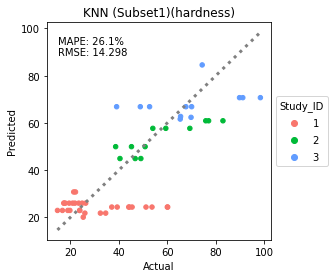

....................................................................................................
Feature: protein, Score: 0.06804
Feature: target moisture, Score: 0.42103
Feature: moisture, Score: 0.27956
Feature: ash, Score: 0.37211
Feature: carbs, Score: 1.00000
Feature: fat, Score: 0.95682
Feature: fiber, Score: 0.00000


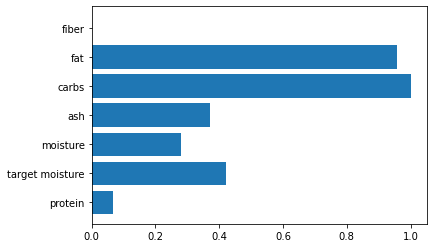

In [64]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut, GroupKFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[columns]

for sub_i in range(len(Subsets_Chew)):

    response = 'hardness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

        #estimator: 100,300,500, ..1000 (did not matter)  lambda: 1.0  max_depth: 4

    param_grid = {
        'n_neighbors': [3,5,7,9]
    }
    ks =[3,5,7,9] # 5
    final_importance, final_importance_noabs=list(), list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = KNeighborsRegressor()#


    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_,predictions_train, y_trues_train = list(), list(), list(), list()
    labels, best_params= list(), list()
    importances, no_abs_importance=[],[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])


       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        #1 (return), 2 (root), 3 train predict, 4 eval
        reg = GridSearchCV(estimator=est,return_train_score=True, param_grid=param_grid, scoring='neg_root_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train)
        reg.cv_results_['mean_test_score']
        # 
        print("Mean_val_score  ", reg.cv_results_['mean_test_score'])
        print("Mean_train_score  ", reg.cv_results_['mean_train_score'])
        print("Ratio test/train  ", reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])
        best_params.append(reg.best_params_)
        print("Best parameters  ", reg.best_params_)
        print("Best parameters test score ",np.abs(reg.cv_results_['mean_test_score'][reg.best_index_]))
        print("Best parameters train score ",np.abs(reg.cv_results_['mean_train_score'][reg.best_index_]))
        print("Best parameters ratio test/train ",(reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])[reg.best_index_])

      #  print(reg)
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())
        prediction_tr = reg.predict(X_train)

        predictions_train.extend(prediction_tr)
        y_trues_train.extend(y_train.ravel())

        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          

        results =  permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
        print(results['importances_mean'])
        importances.append(np.abs(results['importances_mean']))
        no_abs_importance.append(results['importances_mean'])
        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    #x=np.abs(importance)
    print('before ',importance)

    no_abs_importance = np.array(no_abs_importance).mean(0)

    importance = (importance-min(importance))/(max(importance)-min(importance))
    print('after ',importance)

    if not np.isnan(importance[0]):
        final_importance.append(importance)
        
    if not np.isnan(no_abs_importance[0]):
        final_importance_noabs.append(no_abs_importance)

    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Root Mean Squared Train Error (RMSE): %.3f' % mean_squared_error(y_trues_train, predictions_train, squared=False)) 

    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean Absolute Percentage Error (MAPE): {error4:.1f}%')
    print(f'Mean Absolute Percentage Train Error (MAPE): {mean_absolute_percentage_error(y_trues_train, predictions_train):.1f}%')


    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('KNN (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)

    fs_scores=[]
    for i,v in enumerate(final_importance):
        print('Feature: %0s, Score: %.5f' % (features_all.iloc[:,feat].columns[i],v))
        fs_scores.append('%0s %.5f' % (features_all.iloc[:,feat].columns[i],v))
    pyplot.barh(features_all.iloc[:,feat].columns, final_importance)
    pyplot.show()
        

In [65]:
np.savetxt(fname='fs_best_params_'+response+'.txt' , X=best_params, fmt='%s')


In [66]:
np.savetxt(fname='./fs_scores_knn_'+response+'.txt',X=fs_scores,fmt='%s')

# On selected features

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Hardness
0   46.7090
1   40.4365
2   49.0595
3   38.6525
4   50.8115
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 4 candidates, totalling 44 fits
Mean_val_score   [-160.72235288 -235.29565276 -266.13009151 -318.9509681 ]
Mean_train_score   [ -22.82287008  -48.03792632  -84.40170831 -129.69808964]
Ratio test/train   [7.04216219 4.8981226  3.15313631 2.45918015]
Best parameters   {'n_neighbors': 3}
Best parameters test score  12

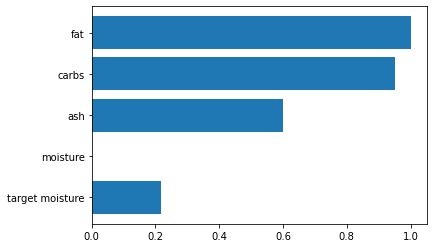

[1, 2, 3, 4, 5]
Number of features: 5
Features: Index(['target moisture', 'moisture', 'ash', 'carbs', 'fat'], dtype='object')
Root Mean Squared Error (RMSE): 10.389
Root Mean Squared Train Error (RMSE): 3.979
Adjusted r2_score: 0.761
r2_score: 0.784
Mean Absolute Percentage Error (MAPE): 19.9%
Mean Absolute Percentage Train Error (MAPE): 0.1%


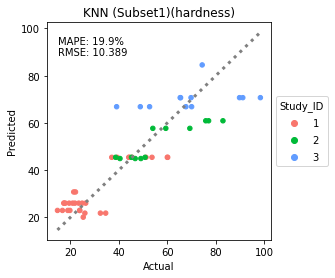

....................................................................................................
Feature: 0, Score: 0.21793
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.59997
Feature: 3, Score: 0.94994
Feature: 4, Score: 1.00000


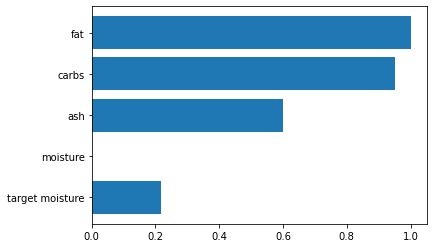

In [40]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut, GroupKFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[['target moisture','moisture','ash','carbs','fat']]

for sub_i in range(len(Subsets_Chew)):

    response = 'hardness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

        #estimator: 100,300,500, ..1000 (did not matter)  lambda: 1.0  max_depth: 4

    param_grid = {
        'n_neighbors': [3,5,7,9]
    }
    ks =[3,5,7,9] # 5
    final_importance=list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = KNeighborsRegressor()#


    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_,predictions_train, y_trues_train = list(), list(), list(), list()
    labels, best_params= list(), list()
    importances=[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])


       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        #1 (return), 2 (root), 3 train predict, 4 eval
        reg = GridSearchCV(estimator=est,return_train_score=True, param_grid=param_grid, scoring='neg_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train)
        # 
        print("Mean_val_score  ", reg.cv_results_['mean_test_score'])
        print("Mean_train_score  ", reg.cv_results_['mean_train_score'])
        print("Ratio test/train  ", reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])

        print("Best parameters  ", reg.best_params_)
        best_params.append(reg.best_params_)

        print("Best parameters test score ",np.sqrt(np.abs(reg.cv_results_['mean_test_score'][reg.best_index_])))
        print("Best parameters train score ",np.sqrt(np.abs(reg.cv_results_['mean_train_score'][reg.best_index_])))
        print("Best parameters ratio test/train ",(reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])[reg.best_index_])

      #  print(reg)
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())

        prediction_tr = reg.predict(X_train)
        predictions_train.extend(prediction_tr)
        y_trues_train.extend(y_train.ravel())

        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          

        results =  permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
       # print(results)
        importance = results.importances_mean
        x=np.abs(importance)

        importance = (x-min(x))/(max(x)-min(x))
        # summarize feature importance
        importances.append(importance)


        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    x=np.abs(importance)

    importance = (x-min(x))/(max(x)-min(x))
    if not np.isnan(importance[0]):
        final_importance.append(importance)
  #  for i,v in enumerate(importance):
  #      print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Root Mean Squared Train Error (RMSE): %.3f' % mean_squared_error(y_trues_train, predictions_train, squared=False)) 

    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean Absolute Percentage Error (MAPE): {error4:.1f}%')
    print(f'Mean Absolute Percentage Train Error (MAPE): {mean_absolute_percentage_error(y_trues_train, predictions_train):.1f}%')

    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('KNN (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)
    x=np.abs(final_importance)

    importance = (x-min(x))/(max(x)-min(x))
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()

In [41]:
np.savetxt(fname='best_params_'+response+'.txt' , X=best_params, fmt='%s')
